# Pros of adding details

author: laquitainesteeve@gmail.com

Execution time:

Tested on Ubuntu 24.04.1 LTS (32 cores, 188 GB RAM, Intel(R) Core(TM) i9-14900K ＠3.2 GHz/5.8 GHz) with RTX 5090 GPU with 40GB VRAM

Prerequisites:
- 13 GB of storage for 1500 templates
- kilosort4 sorting extractors

RESULTS:

- **cell density**: 
    - High density makes spike sorting particularly difficult since so many similar waveforms are picked up by each electrode, due to increased signal overlap, noise, and spike separability.
    - The Buccino model places neurons sparsely in space, unrealistically so compared to real brain tissue. With fewer neurons, each spike is cleaner, and less overlapping occurs. If spike sorting isn't picking up enough units, you could just add more electrodes, because the neurons are so sparse that each electrode captures distinct spikes and more spatial sampling produces more units detected, without much confusion. In real tissue (high cell density), if you only capture 10% of the neurons, adding more probes won't scale yield linearly. You'll still get many overlapping spikes at each site. You'll hit the same separability limits. To improve yield in this case, you must increase electrode density (more sites per mm, closer spacing), which would produce better spatial resolution for disentangling overlapping spikes.
    - Reproducing experimentally-validated cell density and number of cells within 50 micron, allows us to make precise quantitative predictions about the single-unit and multi-unit yields that should be observed in vivo, which are experimentally testable.
    - **distribution of cell pairwise distances**: this parameter cannot be controlled to match experimentally validated locations, constrained by cell morphologies. Only the minimum distance can be controlled and the cells are randomly positioned. We position cells based identified in vivo constrains.
        - With the default overhang of 30 um, and 250 simulated cells, it is not possible to reproduce the average cell distances and density observed in vivo with mearec. Even a minimum distance of 0 um (min_dist paramer) produces an average cell distance of 29 um which is twice the in vivo distance of 14.8 um. The best match we can obtain is an average distance of 29 um, minimum of 4.8 um and max of 91 um against 15, 1.6 and 44 ums in the biophysical model. The original Buccino model display much larger values with 36, 25 and 66 ums.
        - One needs to increase the number of cells to match in vivo count within 50 um and to reduce the overhang to 20 um, in addition a minimum distance of 0 um.

`- **exc/inh ratio**: Buccino has twice more inhibitory relative to the inhibitory/excitatory ratio seen in vivo. Because the modeled inhibitory cells 
have higher firing rates than excitatory cells, this model will predict higher single-unit yield and sorting accuracy.


Methods:

- Buccino model: we assumed the model uses the default parameters, with each site model with a spatial extent of 10 contacts (ncontacts=10), with an x offset of 0, such that the MEA is not centered in the cell population.
    - 250 neurons: 
    - neuron locations cannot be closer than the min_dist parameter (default 25)
    - no cell metadata
    - channel location at x are all zero (default, inferred from doing running simulations) 

- We simulated one intermediate dataset with the same cell counts as npx_spont (100GB, 78 min). Because yield did not decrease to match npx_spont, but rather increased we simulated lower cell counts, we hereafter simulate a lower cell counts with the same exc/inh ratio (25GB, 23) for its efficiency. 10 simulations require take 1 TB storage! This setup is much faster to sort (10 min max)

- Buccino's model overhang: 30 (default) # extension in un beyond MEA boundaries for neuron locations (if lim is null)

- firing_range: no max_rate parameters so we matched min_rate, and firing exc and inh stds and check the resulting max_rate

TODO:
- upload the recordings and sorting extractors to dandi archive (if possible)


## Setup 

Activate mearec virtual environment

In [1]:
%%time
%load_ext autoreload
%autoreload 2

# import packages
import os 
import MEArec as mr
import numpy as np
import spikeinterface.extractors as se 
import spikeinterface.sorters as sorters 
import spikeinterface.comparison as sc  
from matplotlib import pyplot as plt;
import spikeinterface as si
from spikeinterface.curation import remove_excess_spikes
from spikeinterface import extract_waveforms
import spikeinterface.qualitymetrics as sqm
import spikeinterface.core.template_tools as ttools
from numpy.linalg import norm as lalgnorm
import warnings
from scipy.spatial.distance import cdist
import json 

warnings.filterwarnings('ignore')

# SET PROJECT PATH

PROJ_PATH = "/home/steeve/steeve/epfl/code/spikebias/"
os.chdir(PROJ_PATH)

# import custom package
from src.nodes.validation import firing_rate as fr
from src.nodes.analysis.failures import isolation

# parameters
DURATION_S = 600 # duration of recording period considered in seconds

# SET DATA PATHS

# original buccino simulation
RECORDING_BUCCINO_PATH = 'dataset/01_intermediate/preprocessing/recording_buccino/'
GROUND_TRUTH_BUCCINO_PATH = 'dataset/00_raw/ground_truth_buccino/'
WAVEFORM_GT_BUCCINO_PATH =  './temp/pros_of_details/waveformextractor_buccino/'

# setup simulation common template parameters
DATA_PATH = './temp/pros_of_details/'
CELLS_PATH = mr.get_default_cell_models_folder()

# parameter Buccino copy
TEMPLATE_PARAMS_PATH = './assets/mearec/global_templates.json' # templates used for all simulations
TEMPLATES_PATH = './temp/pros_of_details/templates.h5' # warning initially was not 1500 templates but much less 200 - check if that has an effect
INPUT_PARAMS_S1_PATH =  './assets/mearec/buccino_s1/input_params.json'
OUTPUT_PARAMS_S1_PATH = './assets/mearec/buccino_s1/output_params.json'
RECORDING_S1_H5_PATH = './temp/pros_of_details/recordings.h5'
RECORDING_S1_PATH = 'dataset/00_raw/recording_buccino_s1/'
GROUND_TRUTH_S1_PATH = 'dataset/00_raw/ground_truth_buccino_s1/'
WAVEFORM_GT_S1_PATH =  './temp/pros_of_details/waveformextractor_buccino_s1/'

# parameters synthetic 2
INPUT_PARAMS_S2_PATH =  './assets/mearec/buccino_s2/input_params.json'
OUTPUT_PARAMS_S2_PATH = './assets/mearec/buccino_s2/output_params.json'
RECORDING_S2_H5_PATH = './temp/pros_of_details/recordings_s2.h5'
RECORDING_S2_PATH = 'dataset/00_raw/recording_buccino_s2/'
GROUND_TRUTH_S2_PATH = 'dataset/00_raw/ground_truth_buccino_s2/'
WAVEFORM_GT_S2_PATH =  './temp/pros_of_details/waveformextractor_buccino_s2/'

# parameters synthetic 3
INPUT_PARAMS_S3_PATH =  './assets/mearec/buccino_s3/input_params.json'
OUTPUT_PARAMS_S3_PATH = './assets/mearec/buccino_s3/output_params.json'
RECORDING_S3_H5_PATH = './temp/pros_of_details/recordings_s3.h5'
RECORDING_S3_PATH = 'dataset/00_raw/recording_buccino_s3/'
GROUND_TRUTH_S3_PATH = 'dataset/00_raw/ground_truth_buccino_s3/'
WAVEFORM_GT_S3_PATH =  './temp/pros_of_details/waveformextractor_buccino_s3/'

# parameters synthetic 4
INPUT_PARAMS_S4_PATH =  './assets/mearec/buccino_s4/input_params.json'
OUTPUT_PARAMS_S4_PATH = './assets/mearec/buccino_s4/output_params.json'
RECORDING_S4_H5_PATH = './temp/pros_of_details/recordings_s4.h5'
RECORDING_S4_PATH = 'dataset/00_raw/recording_buccino_s4/'
GROUND_TRUTH_S4_PATH = 'dataset/00_raw/ground_truth_buccino_s4/'
WAVEFORM_GT_S4_PATH =  './temp/pros_of_details/waveformextractor_buccino_s4/'

# npx_spont
RECORDING_NS_PATH = 'dataset/01_intermediate/preprocessing/recording_npx_spont/'
GROUND_TRUTH_NS_PATH = 'dataset/00_raw/ground_truth_npx_spont/'
WAVEFORM_GT_NS_PATH = 'dataset/01_intermediate/waveforms/ground_truth_npx_spont/'
SORTING_KS4_NS_PATH = 'dataset/01_intermediate/sorting/npx_spont/SortingKS4_10m'

# parallel processing parameters
save_recording_params = {'n_jobs':20, 'verbose':True, 'progress_bar':True, 'overwrite':True, 'dtype':'float32', 'chunk_size': 50000}

# parallel processing parameters 
job_kwargs = dict(n_jobs=-1, chunk_duration="1s", progress_bar=True)
savefig_cfg = {"transparent":True, "dpi": 300}

CPU times: user 3.82 s, sys: 1.88 s, total: 5.71 s
Wall time: 878 ms


## Custom functions

In [2]:
# UTILS 

def _euclidean_distance(coord_1, coord_2):
    return np.sqrt(np.sum((coord_1 - coord_2) ** 2))


def mad(data):
    mean_data = np.mean(data)
    return np.mean(np.absolute(data - mean_data))


def get_mad_ratio(spike_amp, noise_amp):
    """calculate an sd_ratio robust to outliers

    Args:
        spike_amp (_type_): _description_
        noise_amp (_type_): _description_

    Returns:
        _type_: _description_
    """
    mad_unit = mad(spike_amp)  # twice smaller than std
    mad_noise = mad(noise_amp)
    return mad_unit / mad_noise


def get_best_site_mad_noise(we, max_chids, unit):

    # get waveforms
    wv, _ = we.get_waveforms(unit_id=unit, with_index=True)

    # get channel ids (sparse)
    c_ids = we.sparsity.unit_id_to_channel_ids[unit]

    # get nearest channel
    max_chid = max_chids[unit]
    max_chid_ix = np.where(c_ids == max_chid)[0][0]
    return wv[:, :, max_chid_ix].flatten()


def get_waveform_amplitudes_per_unit(We):
    return si.postprocessing.compute_spike_amplitudes(We, peak_sign="neg", outputs="by_unit")[0]


def get_cell_locations(GroundTruth):

    x = GroundTruth.get_property('x')
    y = GroundTruth.get_property('y')
    z = GroundTruth.get_property('z')
    return np.array([x, y, z]).T


def get_cell_to_cell_distances(GroundTruth):
   
    x = GroundTruth.get_property('x')
    y = GroundTruth.get_property('y')
    z = GroundTruth.get_property('z')
    cell_pos = np.array([x, y, z]).T
    return cdist(cell_pos, cell_pos, metric='euclidean')


# SIMULATE SYNTHETIC RECORDING WITH MEAREC

def simulate_synthetic_recording_with_mearec(rec_prms: dict, layer:str, templates_path:str, recording_clone_h5_path:str):

    # generate simulated recording (takes 22 min)
    rec_gen = mr.gen_recordings(params=rec_prms, templates=templates_path)

    # save simulated recording
    mr.save_recording_generator(rec_gen, recording_clone_h5_path)

    # load recording h5 file
    RecordingClone = se.MEArecRecordingExtractor(recording_clone_h5_path) 
    RecordingClone.set_property("layers", np.array([layer]*384)) # add layer metadata

    # load ground truth
    SortingClone = se.MEArecSortingExtractor(recording_clone_h5_path)

    # delete intermediate h5 file
    os.remove(recording_clone_h5_path)
    return RecordingClone, SortingClone, rec_gen


def set_metadata_to_mearec_simulations(recording_generator, Recording, Sorting):
    
    # set cell features
    features = ['cell_type', 'snr', 'mtype', 'soma_position', 'bursting', 'exp_decay', 'max_spikes_per_burst', 'max_burst_duration']
    n_cells = len(recording_generator.spiketrains)

    # set cell properties in sorting extractor
    for feature in features:
        feature_data = []
        for cell_ix in range(n_cells):
            feature_data.append(recording_generator.spiketrains[cell_ix].annotations[feature])
        Sorting.set_property(feature, np.array(feature_data))

    # set electrode properties in recording extractor
    # by default, channel_locations are attached to Recording extractor
    Recording.set_property('layer', np.array(['L5']*384)) # layer
    return Recording, Sorting


def report_simulation_parameters(rec_gen):
    """
    Reports simulation parameters, checks for bursting, and displays example cell metadata.

    Args:
        rec_gen (RecordingGenerator): The recording generator object.
    """
    # report parameters
    display('Simulation parameters:', rec_gen.info)

    # check bursting
    bursting = []
    for ix in range(250):
        bursting.append(rec_gen.spiketrains[1].annotations['bursting'])
    print('Bursting:', any(bursting))

    # example of a cell metadata
    CELL_IDX = 0
    print('\nExample cell type:', rec_gen.template_celltypes[CELL_IDX])
    display('Its spiking metadata:', rec_gen.spiketrains[CELL_IDX].annotations)
    print('Its spike times:', rec_gen.spiketrains[CELL_IDX].times)


def save_simulation_parameters_to_assets(rec_prms:dict, rec_gen, input_params_path:str, output_params_path:str):
    
    # save input simulation parameters to MEAREC
    with open(input_params_path, 'w') as f:
        json.dump(rec_prms, f, indent=4)

    # save parameters recorded in recording generator
    with open(output_params_path, 'w') as f:
        json.dump(rec_gen.params, f, indent=4)

        
def get_cell_type_property_from_mearec(simulation):
    cell_types = []
    for ix in range(len(simulation.spiketrains)):
        cell_types.append(simulation.spiketrains[ix].annotations['cell_type'])
    return np.array(cell_types)


# DESCRIPTIVE FEATURES

def count_near_cells_within_radius(site_pos, cell_pos, unit_ids, radius=50):
    """
    Counts the number of unique cells within a specified radius from each site.

    Args:
        recording: SpikeInterface RecordingExtractor object.
        sorting: SpikeInterface SortingExtractor object.
        radius (int): Distance threshold in micrometers.

    Returns:
        int: Number of unique cells within the specified radius.
    """
    all_near_cells = []

    # for each site, find cells within the specified radius
    for pos in site_pos:
        tiled = np.tile(pos, (cell_pos.shape[0], 1))
        dist = np.linalg.norm(cell_pos - tiled, axis=1)
        near_cells = unit_ids[dist < radius]
        all_near_cells.extend(near_cells)
    all_near_cells = list(set(all_near_cells))
    return len(all_near_cells)


# QUALITY METRICS FOR A SINGLE UNIT

def get_spatial_spread(
    We, unit_id: int, max_chids: dict, channel_ids, channel_coord
):
    """measure unit's spatial spread

    Args:
        unit_id (int): _description_
        max_chids (dict): _description_
        Recording (_type_): _description_
        channel_ids (_type_): _description_
        channel_coord (_type_): _description_

    Returns:
        _type_: _description_
    """
    # get waveforms
    wv, _ = We.get_waveforms(unit_id=unit_id, with_index=True)    

    # get the site ids (sparse)
    c_ids = We.sparsity.unit_id_to_channel_ids[unit_id]

    # get the nearest site
    max_chid = max_chids[unit_id]
    max_chid_ix = np.where(c_ids == max_chid)[0][0]
    
    # get the average spike on each site
    mean_spikes = wv.mean(axis=0)
    max_spike = mean_spikes[:, max_chid_ix]
    
    # measure the average spike's similarity 
    # of each site to the average spike
    # of the nearest site to the unit
    # (ratio between 0 and 1)
    n_sites = mean_spikes.shape[1]
    cosim_weights = []
    for s_i in range(n_sites):
        cosim_weights.append(
            np.dot(max_spike, mean_spikes[:, s_i])
            / (lalgnorm(max_spike) * lalgnorm(mean_spikes[:, s_i]))
        )
    cosim_weights = np.array(cosim_weights)

    # threshold the similarity metric to be positive
    # we only look at similarity (not inverse similarity (<0))
    cosim_weights[cosim_weights < 0] = 0

    # measure the distance of the site to the nearest site
    # to the unit
    channel_coord = channel_coord[np.isin(channel_ids, c_ids), :]
    try:
        max_chids_coord = channel_coord[max_chid_ix, :]
    except:
        from ipdb import set_trace; set_trace()
        
    dist = []
    for ix, _ in enumerate(c_ids):
        dist.append(_euclidean_distance(max_chids_coord, channel_coord[ix]))
    dist = np.array(dist)

    # return spatial spread
    return {
        "spatial_spread": np.dot(cosim_weights, dist),
        "channel_distance": dist,
        "weights": cosim_weights,
    }


# QUALITY METRICS / SPIKE FEATURES FOR ALL UNITS

def get_firing_rates(sorting, duration_s):
    """
    Plots the firing rate distribution of units in a sorting extractor.

    Parameters:
    - sorting: spikeinterface SortingExtractor
        The sorting extractor containing spike trains.
    - duration_s: the total duration
    - bins: int, optional
        Number of bins for the histogram (default is 20).
    """
    unit_ids = sorting.get_unit_ids()
    firing_rates = [
        len(sorting.get_unit_spike_train(unit_id)) / duration_s
        for unit_id in unit_ids
    ]
    return firing_rates


def get_firing_ranges(waveform_extractor):

    firing_range = sqm.compute_firing_ranges(waveform_extractor=waveform_extractor)
    return np.array(list(firing_range.values()))


def get_waveform_amplitude_medians(waveform_extractor):

    amplitude_medians = sqm.compute_amplitude_medians(waveform_extractor=waveform_extractor)
    return np.array(list(amplitude_medians.values()))


def get_waveform_snr(waveform_extractor):
    snrs = sqm.compute_snrs(waveform_extractor=waveform_extractor)
    return np.array(list(snrs.values()))


def get_spatial_spread_all_units(
    recording_path: str, study_path: str, ms_before=3, ms_after=3, peak_sign="neg"
):
    """get all units' spatial extent metrics

    Args:
        recording_path (str): Path of the Recording Extractor
        study_path (str): _description_
        ms_before (float): _description_
        ms_after (float): _description_

    Returns:
        (dict): spatial spread of each unit
        - key: true unit id
        - value: spatial spread
    
    Prerequisites:
        - have extracted ground truth waveforms
    """
    # takes 1:30 min
    We = si.WaveformExtractor.load_from_folder(study_path)
    
    # get sites' distance to the max site
    # get 3D coordinates
    Rec = si.load_extractor(recording_path)
    channel_coord = Rec.get_probe().contact_positions
    channel_ids = Rec.get_channel_ids()

    # get channels where spike amplitude is maximal
    max_chids = ttools.get_template_extremum_channel(
        We, peak_sign=peak_sign)

    # takes 1:30 min (1310 units)
    spatial_spread = dict()
    for _, unit in enumerate(We.unit_ids):
        spatial_spread[unit] = get_spatial_spread(
            We, unit, max_chids, channel_ids, channel_coord
        )["spatial_spread"]
    return np.array(list(spatial_spread.values()))


def get_mad_ratios(WeOriginal):
    """get mad ratio per unit. Values close to 1 indicate a good isolation of the unit.
    i.e., the mean absolute deviation of the spike amplitude is similar to the mean absolute deviation 
    of the noise amplitude.

    Args:
        WeOriginal (WaveformExtractor): _description_

    Returns:
        np.array: mad ratio per unit
    """
    # pre-compute negative spike amplitudes
    amplitudes_by_unit = get_waveform_amplitudes_per_unit(WeOriginal)

    # get nearest channels
    max_chids = ttools.get_template_extremum_channel(WeOriginal, peak_sign="both")

    # compute mad ratio per unit
    mad_ratio = []
    for unit in WeOriginal.unit_ids:
        noise_amp = get_best_site_mad_noise(WeOriginal, max_chids, unit)
        mad_ratio.append(get_mad_ratio(amplitudes_by_unit[unit], noise_amp))
    return np.array(mad_ratio)


# PLOTS 

def plot_firing_rate_distribution(ax, firing_rates, bins=20, title:str='simulation_name', ylim=(0,60), xlim=(0,25)):
    """
    Plots the firing rate distribution of units in a sorting extractor.

    Parameters:
    - firing rates: firing rates
    - bins: int, optional
        Number of bins for the histogram (default is 20).
    """
    ax.hist(firing_rates, bins=bins, edgecolor='k')
    ax.set_xlabel("Firing rate (Hz)")
    ax.set_ylabel("Unit count")
    ax.set_ylim(ylim)
    ax.set_xlim(xlim)    
    ax.set_title(title)


def plot_firing_ranges_distribution(ax, firing_ranges, bins=20, title:str='simulation_name', ylim=(0,50), xlim=(0,800)):
    """
    Parameters:
    - amplitudes: waveform amplitudes
    - bins: int, optional
        Number of bins for the histogram (default is 20).
    """
    ax.hist(firing_ranges, bins=bins, edgecolor='k')
    ax.set_xlabel("Firing range (Hz)")
    ax.set_ylabel("Unit count")
    ax.set_ylim(ylim)
    ax.set_xlim(xlim)
    ax.set_title(title)


def plot_waveform_amplitude_median_distribution(ax, amplitudes, bins=20, title:str='simulation_name', ylim=(0,50), xlim=(0,800)):
    """
    Parameters:
    - amplitudes: waveform amplitudes
    - bins: int, optional
        Number of bins for the histogram (default is 20).
    """
    ax.hist(amplitudes, bins=bins, edgecolor='k')
    ax.set_xlabel("Amplitudes (uV)")
    ax.set_ylabel("Unit count")
    ax.set_ylim(ylim)
    ax.set_xlim(xlim)
    ax.set_title(title)


def plot_waveform_snr_distribution(ax, snrs, bins=20, title:str='simulation_name', ylim=(0,50), xlim=(0,800)):
    """
    Parameters:
    - snrs: snrs
    - bins: int, optional
        Number of bins for the histogram (default is 20).
    """
    ax.hist(snrs, bins=bins, edgecolor='k')
    ax.set_xlabel("SNR")
    ax.set_ylabel("Unit count")
    ax.set_ylim(ylim)
    ax.set_xlim(xlim)
    ax.set_title(title)


def plot_spatial_spread_distribution(ax, mad_ratio, bins=20, title:str='simulation_name', ylim=(0,50), xlim=(0,800)):
    """
    Parameters:
    - mad_ratio: mad_ratio
    - bins: int, optional
        Number of bins for the histogram (default is 20).
    """
    ax.hist(mad_ratio, bins=bins, edgecolor='k')
    ax.set_xlabel("Spatial spread (a.u)")
    ax.set_ylabel("Unit count")
    ax.set_ylim(ylim)
    ax.set_xlim(xlim)
    ax.set_title(title)


def plot_mad_ratio_distribution(ax, mad_ratios, bins=20, title:str='simulation_name', ylim=(0,50), xlim=(0,800)):
    """
    Parameters:
    - mad_ratios: waveform mean-absolute deviation ratio between spike amplitude and background noise
    - bins: int, optional
        Number of bins for the histogram (default is 20).
    """
    ax.hist(mad_ratios, bins=bins, edgecolor='k')
    ax.set_xlabel("MAD ratios (a.u)")
    ax.set_ylabel("Unit count")
    ax.set_ylim(ylim)
    ax.set_xlim(xlim)
    ax.set_title(title)

# Quality of unit isolation (single-unit yield)

def process_each_experiment(sorted1, sorted2, sorted3, sorted4, sorted5, sorted6, exp_names):
    """
    Process sorting data by retrieving, filtering, and standardizing unit data.
    Keep units in L1 to L6 (in cortex)

    Returns:
        dict: A dictionary containing processed DataFrames for sorting data.
    """
    # get unit data
    sorting_data = {
        exp_names[0]: fr.get_sorted_unit_meta(sorted1),
        exp_names[1]: fr.get_sorted_unit_meta(sorted2),
        exp_names[2]: fr.get_sorted_unit_meta(sorted3),
        exp_names[3]: fr.get_sorted_unit_meta(sorted4),
        exp_names[4]: fr.get_sorted_unit_meta(sorted5),
        exp_names[5]: fr.get_sorted_unit_meta(sorted6)
    }

    # standardize layer 2/3
    for key in sorting_data:
        sorting_data[key]["layer"][
            (sorting_data[key]["layer"] == "L2") | (sorting_data[key]["layer"] == "L3") | (sorting_data[key]["layer"] == "L2_3")
        ] = "L2/3"

    # keep units in cortex
    for key in sorting_data:
        sorting_data[key] = sorting_data[key][
            np.isin(sorting_data[key]["layer"], ["L1", "L2", "L2/3", "L4", "L5", "L6"])
        ]
    return sorting_data

## Simulate intermediate synthetic datasets

In [ ]:
# setup common cell templates, probe, and seed parameters (takes 4,531 secs)
tpl_prms = mr.get_default_templates_params()
tpl_prms['probe'] = 'Neuropixels-384'           # probe
tpl_prms['n'] = 1500                            # (default = 50) number of templates per cell model (minimum that worked to match npx_spont cell counts), I use 1500.
tpl_prms['seed'] = 0                            # setup reproducibility
tpl_prms['overhang'] = 50                       # (default = 30) extension in um beyond MEA boundaries for neuron locations
tpl_prms['ncontacts'] = 1                       # (default = 10) number of contacts per recording site, spatial extent of the electrode over which to average potential
tpl_prms['offset'] = 0                          # (default = 0) x offset; MEA is in the yz plane with x 0 by default. One can center the MEA in cell population by setting x offset.
tpl_prms['xlim'] = [-50, 50]                    # (default = [10,80]) limits ( low high ) for neuron locations in the x-axis (depth)
tpl_prms['ylim'] = None                         # (default = None) limits ( low high ) for neuron locations in the y-axis
tpl_prms['zlim'] = [-1001, 1001]                # (default = None) limits ( low high ) for neuron locations in the z-axis

# create and save waveform templates (10 min for 200 templates per cell, 15 MB)
tpl_gen = mr.gen_templates(cell_models_folder = CELLS_PATH, params = tpl_prms)
mr.save_template_generator(tpl_gen, TEMPLATES_PATH)

In [4]:
# setup common recording parameters
rec_prms = mr.get_default_recordings_params()
rec_prms['spiketrains']['duration'] = 600          # (default=600) recording duration
rec_prms['spiketrains']['min_rate'] = 0.5          # default value
rec_prms['seeds']['spiketrains'] = 0
rec_prms['seeds']['templates'] = 1
rec_prms['seeds']['noise'] = 2
rec_prms['seeds']['convolution'] = 3

# save common template parameters
with open(TEMPLATE_PARAMS_PATH, 'w') as f:
    json.dump(tpl_prms, f, indent=4)

### S1 - clone

In [ ]:
%%time

# setup this simulation's parameters
rec_prms['spiketrains']['n_exc'] = 200
rec_prms['spiketrains']['n_inh'] = 50

# simulate recording with MEArec (23 min)
RecordingClone, SortingClone, RecGen = simulate_synthetic_recording_with_mearec(rec_prms, 'L5', TEMPLATES_PATH, RECORDING_S1_H5_PATH)

# set extractor properties (metadata)
RecordingClone, SortingClone = set_metadata_to_mearec_simulations(RecGen, RecordingClone, SortingClone)

# save extractors
RecordingClone.save(folder=RECORDING_S1_PATH, **save_recording_params)
SortingClone.save(folder=GROUND_TRUTH_S1_PATH, overwrite=True)

# save simulation global parameters (reproducibility)
save_simulation_parameters_to_assets(rec_prms, RecGen, INPUT_PARAMS_S1_PATH, OUTPUT_PARAMS_S1_PATH)

# report parameters
# report_simulation_parameters(RecGen)
# print(si.load_extractor('dataset/00_raw/ground_truth_buccino_clone/').get_property_keys())
# print(si.load_extractor('dataset/00_raw/recording_buccino_clone/').get_property_keys())

Loading templates...
Done loading templates...
Spiketrains seed:  0
dtype float32
Noise Level  10
Templates selection seed:  1
Selecting cells
Padding template edges
Elapsed pad time: 2.610837936401367
Creating time jittering
Elapsed jitter time: 4.747773170471191
Smoothing templates
Computing spike train SNR
Adding spiketrain annotations
Convolution seed:  3
Electrode modulaton
Adding noise
Noise seed:  2
Filtering
Band-pass cutoff [ 300. 6000.] Hz
Elapsed time:  1426.0324536029948
write_binary_recording with n_jobs = 20 and chunk_size = 50000


write_binary_recording:   0%|          | 0/384 [00:00<?, ?it/s]

CPU times: user 21min 21s, sys: 2min 34s, total: 23min 55s
Wall time: 24min 32s


### S2 - cell count/density

Here we match <u>cell count and density</u>: 5x more exc. cells and 2X more inh. than Buccino; cell dist. (required for this important cell count) - 25x smaller distances than Buccino, else we get the RuntimeError: Templates could not be selected.  Decrease number of spiketrains, decrease 'min_dist', or use more templates.

see https://spikeinterface.github.io/blog/collision-paper-generate-recordings/

Loading templates...
Done loading templates...
Spiketrains seed:  0
dtype float32
Noise Level  10
Templates selection seed:  1
Selecting cells
Padding template edges
Elapsed pad time: 8.170446634292603
Creating time jittering
Elapsed jitter time: 22.648691415786743
Smoothing templates
Computing spike train SNR
Adding spiketrain annotations
Convolution seed:  3
Electrode modulaton
Adding noise
Noise seed:  2
Filtering
Band-pass cutoff [ 300. 6000.] Hz
Elapsed time:  4480.859813356999

In [5]:
# change cell count and density parameters
# inh., exc. cell counts and min cell-to-cell distances are matched to npx_spont's
rec_prms['spiketrains']['n_exc'] = 1279         # (default = 200), matched to npx_spont
rec_prms['spiketrains']['n_inh'] = 109          # (default = 50), matched to npx_spont
rec_prms['templates']['min_dist'] = 0         # (default = 25), chosen to match mean cell-to-cell distance

# simulate recording with MEArec (83 min)
RecordingS2, SortingS2, RecGenS2 = simulate_synthetic_recording_with_mearec(rec_prms, 'L5', TEMPLATES_PATH, RECORDING_S2_H5_PATH)

# set extractor properties (metadata)
RecordingS2, SortingS2 = set_metadata_to_mearec_simulations(RecGenS2, RecordingS2, SortingS2)

# save extractors
RecordingS2.save(folder=RECORDING_S2_PATH, **save_recording_params)
SortingS2.save(folder=GROUND_TRUTH_S2_PATH, overwrite=True)

# save simulation global parameters (reproducibility)
save_simulation_parameters_to_assets(rec_prms, RecGenS2, INPUT_PARAMS_S2_PATH, OUTPUT_PARAMS_S2_PATH)

# report parameters
# report_simulation_parameters(RecGen)
print(si.load_extractor(GROUND_TRUTH_S2_PATH).get_property_keys())
print(si.load_extractor(RECORDING_S2_PATH).get_property_keys())

Loading templates...
Done loading templates...
Spiketrains seed:  0
dtype float32
Noise Level  10
Templates selection seed:  1
Selecting cells
Padding template edges
Elapsed pad time: 8.170446634292603
Creating time jittering
Elapsed jitter time: 22.648691415786743
Smoothing templates
Computing spike train SNR
Adding spiketrain annotations
Convolution seed:  3
Electrode modulaton
Adding noise
Noise seed:  2
Filtering
Band-pass cutoff [ 300. 6000.] Hz
Elapsed time:  4480.859813356999
write_binary_recording with n_jobs = 20 and chunk_size = 50000


write_binary_recording:   0%|          | 0/384 [00:00<?, ?it/s]

['soma_position', 'bursting', 'mtype', 'exp_decay', 'max_burst_duration', 'max_spikes_per_burst', 'cell_type', 'snr']
['gain_to_uV', 'offset_to_uV', 'contact_vector', 'location', 'group', 'layer', 'channel_name', 'layers']


### S3 - FR

In [ ]:
%%time

# change firing rates parameters, keep exc/inh ratio the same (sim too heavy to match the cells counts for all sims.)
rec_prms['spiketrains']['n_exc'] = 200
rec_prms['spiketrains']['n_inh'] = 17
rec_prms['templates']['min_dist'] = 1.6

rec_prms['spiketrains']['f_exc'] = 0.3    # mean firing rate of excitatory cells in Hz (15 x lower)
rec_prms['spiketrains']['f_inh'] = 1      # mean firing rate of inhibitory cells in Hz (10 x lower)
rec_prms['spiketrains']['min_rate'] = 0   # same as npx_spont for 10 min recording (all cells fired for the entire recording)

# simulate recording with MEArec (23 min)
RecordingS3, SortingS3, RecGenS3 = simulate_synthetic_recording_with_mearec(rec_prms, 'L5', TEMPLATES_PATH, RECORDING_S3_H5_PATH)

# set extractor properties (metadata)
RecordingS3, SortingS3 = set_metadata_to_mearec_simulations(RecGenS3, RecordingS3, SortingS3)

# save extractors
RecordingS3.save(folder=RECORDING_S3_PATH, **save_recording_params)
SortingS3.save(folder=GROUND_TRUTH_S3_PATH, overwrite=True)

# save simulation global parameters (reproducibility)
save_simulation_parameters_to_assets(rec_prms, RecGenS3, INPUT_PARAMS_S3_PATH, OUTPUT_PARAMS_S3_PATH)

# report parameters
# report_simulation_parameters(RecGen)

### S4 - FR range

In [ ]:
%%time

# change firing range (by adjusting st_exc and st_inh)
# check with:
#   firing_ranges = get_firing_ranges(WeGtNS)
#   display(firing_ranges.max())
#   display(firing_ranges[SortingGtNS.get_property('synapse_class')=='EXC'].std())
#   display(firing_ranges[SortingGtNS.get_property('synapse_class')=='INH'].std())
rec_prms['spiketrains']['n_exc'] = 200
rec_prms['spiketrains']['n_inh'] = 17
rec_prms['templates']['min_dist'] = 1.6
rec_prms['spiketrains']['f_exc'] = 0.3    # mean firing rate of exc cells in Hz (15 x lower)
rec_prms['spiketrains']['f_inh'] = 1      # mean firing rate of inh cells in Hz (10 x lower)
rec_prms['spiketrains']['min_rate'] = 0   # same as npx_spont for 10 min recording (all cells fired for the entire recording)

rec_prms['spiketrains']['st_exc'] = 0.20  # firing rate standard deviation of excitatory cells in Hz (produces empirically 0.34)
rec_prms['spiketrains']['st_inh'] = 0.45  # firing rate standard deviation of inhibitory cells in Hz (produces empirically 0.30)

# simulate recording with MEArec (23 min)
RecordingS4, SortingS4, RecGenS4 = simulate_synthetic_recording_with_mearec(rec_prms, 'L5', TEMPLATES_PATH, RECORDING_S4_H5_PATH)

# set extractor properties (metadata)
RecordingS4, SortingS4 = set_metadata_to_mearec_simulations(RecGenS4, RecordingS4, SortingS4)

# save extractors
RecordingS4.save(folder=RECORDING_S4_PATH, **save_recording_params)
SortingS4.save(folder=GROUND_TRUTH_S4_PATH, overwrite=True)

# save simulation global parameters (reproducibility)
save_simulation_parameters_to_assets(rec_prms, RecGenS4, INPUT_PARAMS_S4_PATH, OUTPUT_PARAMS_S4_PATH)

# report parameters
# report_simulation_parameters(RecGen)

### S5 - SNR

In [ ]:
%%time

# change spike amplitudes
rec_prms['spiketrains']['n_exc'] = 200
rec_prms['spiketrains']['n_inh'] = 17
rec_prms['templates']['min_dist'] = 1.6
rec_prms['spiketrains']['f_exc'] = 0.3    # mean firing rate of exc cells in Hz (15 x lower)
rec_prms['spiketrains']['f_inh'] = 1      # mean firing rate of inh cells in Hz (10 x lower)
rec_prms['spiketrains']['min_rate'] = 0   # same as npx_spont for 10 min recording (all cells fired for the entire recording)
rec_prms['spiketrains']['st_exc'] = 0.30  # firing rate standard deviation of excitatory cells in Hz ()
rec_prms['spiketrains']['st_inh'] = 0.35  # firing rate standard deviation of inhibitory cells in Hz (produces empirically 0.26)

rec_prms['templates']['min_amp'] = 100    # minimum spike amplitude in uV
rec_prms['templates']['max_amp'] = 600    # maximum spike amplitude in uV

# simulate synthetic recording with MEArec (takes 78 min)
RecordingS4, SortingS4, RecGenS4 = simulate_synthetic_recording_with_mearec(rec_prms, 'L5', TEMPLATES_PATH, RECORDING_S4_H5_PATH, RECORDING_S4_PATH, GROUND_TRUTH_S4_PATH, N_JOBS, CHUNKS)

# report parameters
report_simulation_parameters(RecGenS4)

## Load/compute data

In [2]:
%%time

# load orginal Buccino (already bandpass filtered 300 - 6000 Hz)
RecordingBuccino = si.load_extractor(RECORDING_BUCCINO_PATH)
SortingGtBuccino = si.load_extractor(GROUND_TRUTH_BUCCINO_PATH)

# load Buccino clone (already bandpass filtered 300 - 6000 Hz)
RecordingClone = si.load_extractor(RECORDING_CLONE_PATH)
SortingGtClone = si.load_extractor(GROUND_TRUTH_CLONE_PATH)

# load Buccino S2 (already bandpass filtered 300 - 6000 Hz)
RecordingS2 = si.load_extractor(RECORDING_S2_PATH)
SortingGtS2 = si.load_extractor(GROUND_TRUTH_S2_PATH)

# load Buccino S3 (already bandpass filtered 300 - 6000 Hz)
RecordingS3 = si.load_extractor(RECORDING_S3_PATH)
SortingGtS3 = si.load_extractor(GROUND_TRUTH_S3_PATH)

# load Buccino S4 (already bandpass filtered 300 - 6000 Hz)
RecordingS4 = si.load_extractor(RECORDING_S4_PATH)
SortingGtS4 = si.load_extractor(GROUND_TRUTH_S4_PATH)

# load npx_spont (preprocessed high-pass filtered >300 Hz)
RecordingNS = si.load_extractor(RECORDING_NS_PATH)
SortingGtNS = si.load_extractor(GROUND_TRUTH_NS_PATH)
SortingGtNS = remove_excess_spikes(SortingGtNS, RecordingNS)
SortingGtNS = SortingGtNS.frame_slice(start_frame=0, end_frame=RecordingNS.get_sampling_frequency() * DURATION_S)

# extract waveforms (typically takes 20 secs)
WeGtOriginal = extract_waveforms(RecordingBuccino, SortingGtBuccino, WAVEFORM_GT_BUCCINO_PATH,
    sparse=True, ms_before=3.0, ms_after=3.0, max_spikes_per_unit=500, unit_batch_size=200,
    overwrite=True, seed=0, **job_kwargs)

WeGtClone = extract_waveforms(RecordingClone, SortingGtClone, WAVEFORM_GT_CLONE_PATH,
    sparse=True, ms_before=3.0, ms_after=3.0, max_spikes_per_unit=500, unit_batch_size=200,
    overwrite=True, seed=0, **job_kwargs)

WeGtS2 = extract_waveforms(RecordingS2, SortingGtS2, WAVEFORM_GT_S2_PATH,
    sparse=True, ms_before=3.0, ms_after=3.0, max_spikes_per_unit=500, unit_batch_size=200,
    overwrite=True, seed=0, **job_kwargs)

WeGtS3 = extract_waveforms(RecordingS3, SortingGtS3, WAVEFORM_GT_S3_PATH,
    sparse=True, ms_before=3.0, ms_after=3.0, max_spikes_per_unit=500, unit_batch_size=200,
    overwrite=True, seed=0, **job_kwargs)

WeGtS4 = extract_waveforms(RecordingS4, SortingGtS4, WAVEFORM_GT_S4_PATH,
    sparse=True, ms_before=3.0, ms_after=3.0, max_spikes_per_unit=500, unit_batch_size=200,
    overwrite=True, seed=0, **job_kwargs)

WeGtNS = extract_waveforms(RecordingNS, SortingGtNS, WAVEFORM_GT_NS_PATH,
    sparse=True, ms_before=3.0, ms_after=3.0, max_spikes_per_unit=500, unit_batch_size=200,
    overwrite=True, seed=0, **job_kwargs)

extract waveforms shared_memory multi buffer:   0%|          | 0/600 [00:00<?, ?it/s]

extract waveforms shared_memory multi buffer:   0%|          | 0/600 [00:00<?, ?it/s]

extract waveforms memmap multi buffer:   0%|          | 0/600 [00:00<?, ?it/s]

extract waveforms shared_memory multi buffer:   0%|          | 0/600 [00:00<?, ?it/s]

extract waveforms shared_memory multi buffer:   0%|          | 0/600 [00:00<?, ?it/s]

extract waveforms memmap multi buffer:   0%|          | 0/600 [00:00<?, ?it/s]

extract waveforms shared_memory multi buffer:   0%|          | 0/600 [00:00<?, ?it/s]

extract waveforms shared_memory multi buffer:   0%|          | 0/600 [00:00<?, ?it/s]

extract waveforms shared_memory multi buffer:   0%|          | 0/600 [00:00<?, ?it/s]

extract waveforms shared_memory multi buffer:   0%|          | 0/600 [00:00<?, ?it/s]

extract waveforms shared_memory multi buffer:   0%|          | 0/600 [00:00<?, ?it/s]

extract waveforms shared_memory multi buffer:   0%|          | 0/600 [00:00<?, ?it/s]

extract waveforms shared_memory multi buffer:   0%|          | 0/600 [00:00<?, ?it/s]

extract waveforms memmap multi buffer:   0%|          | 0/600 [00:00<?, ?it/s]

extract waveforms shared_memory multi buffer:   0%|          | 0/600 [00:00<?, ?it/s]

extract waveforms shared_memory multi buffer:   0%|          | 0/600 [00:00<?, ?it/s]

extract waveforms memmap multi buffer:   0%|          | 0/600 [00:00<?, ?it/s]

extract waveforms shared_memory multi buffer:   0%|          | 0/600 [00:00<?, ?it/s]

extract waveforms shared_memory multi buffer:   0%|          | 0/600 [00:00<?, ?it/s]

extract waveforms memmap multi buffer:   0%|          | 0/600 [00:00<?, ?it/s]

extract waveforms shared_memory multi buffer:   0%|          | 0/600 [00:00<?, ?it/s]

extract waveforms shared_memory multi buffer:   0%|          | 0/600 [00:00<?, ?it/s]

extract waveforms shared_memory multi buffer:   0%|          | 0/600 [00:00<?, ?it/s]

extract waveforms shared_memory multi buffer:   0%|          | 0/600 [00:00<?, ?it/s]

extract waveforms shared_memory multi buffer:   0%|          | 0/600 [00:00<?, ?it/s]

extract waveforms shared_memory multi buffer:   0%|          | 0/600 [00:00<?, ?it/s]

extract waveforms shared_memory multi buffer:   0%|          | 0/600 [00:00<?, ?it/s]

extract waveforms memmap multi buffer:   0%|          | 0/600 [00:00<?, ?it/s]

CPU times: user 51.6 s, sys: 1min 34s, total: 2min 26s
Wall time: 3min 16s


## Compute/plot quality features

extract amplitudes:   0%|          | 0/600 [00:00<?, ?it/s]

extract amplitudes:   0%|          | 0/600 [00:00<?, ?it/s]

extract amplitudes:   0%|          | 0/600 [00:00<?, ?it/s]

extract amplitudes:   0%|          | 0/600 [00:00<?, ?it/s]

extract amplitudes:   0%|          | 0/600 [00:00<?, ?it/s]

extract amplitudes:   0%|          | 0/600 [00:00<?, ?it/s]

CPU times: user 1min 24s, sys: 30.6 s, total: 1min 55s
Wall time: 2min 49s


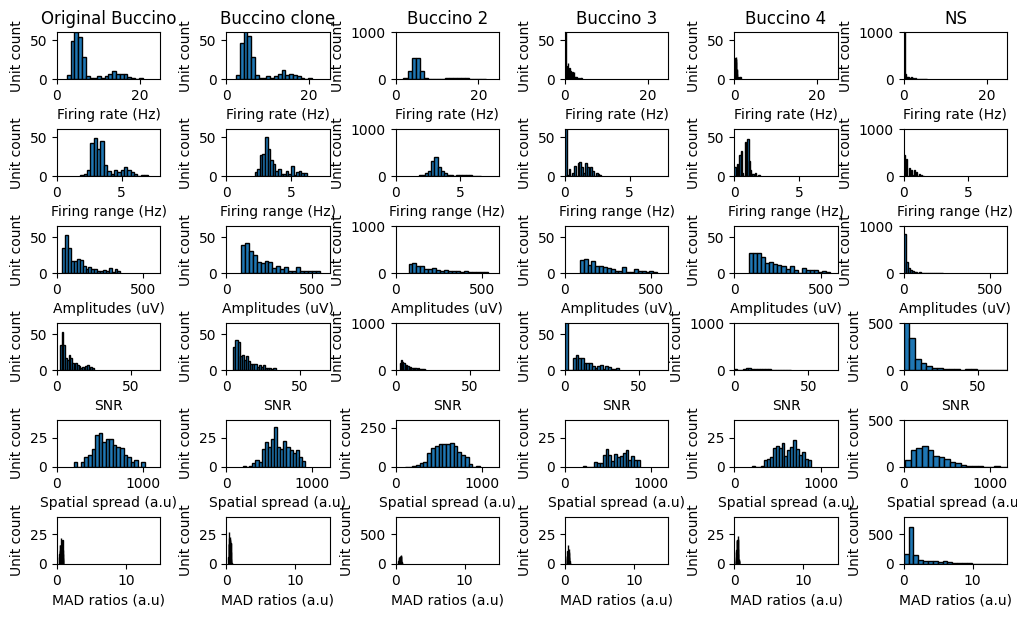

In [16]:
%%time

# setup  plot 
fig, axes = plt.subplots(6,6, figsize=(10,6))

# CELL SPIKING FEATURES ---------------


# firing rates
firing_rates = get_firing_rates(SortingGtBuccino, duration_s=600) # original Buccino
plot_firing_rate_distribution(axes[0,0], firing_rates, title='Original Buccino', ylim=(0,60), xlim=(0,25))

firing_rates = get_firing_rates(SortingGtClone, duration_s=600) # our Buccino clone
plot_firing_rate_distribution(axes[0,1], firing_rates, title='Buccino clone', ylim=(0,60), xlim=(0,25))

firing_rates = get_firing_rates(SortingGtS2, duration_s=600) # our S2
plot_firing_rate_distribution(axes[0,2], firing_rates, title='Buccino 2', ylim=(0,1000), xlim=(0,25))

firing_rates = get_firing_rates(SortingGtS3, duration_s=600) # our S3
plot_firing_rate_distribution(axes[0,3], firing_rates, title='Buccino 3', ylim=(0,60), xlim=(0,25))

firing_rates = get_firing_rates(SortingGtS4, duration_s=600) # our S3
plot_firing_rate_distribution(axes[0,4], firing_rates, title='Buccino 4', ylim=(0,60), xlim=(0,25))

firing_rates = get_firing_rates(SortingGtNS, duration_s=600) # npx_spont
plot_firing_rate_distribution(axes[0,5], firing_rates, title='NS', ylim=(0,1000), xlim=(0,25))


# firing range
firing_ranges = get_firing_ranges(WeGtOriginal)
plot_firing_ranges_distribution(axes[1,0], firing_ranges, title='', ylim=(0,60), xlim=(0,8))

firing_ranges = get_firing_ranges(WeGtClone)
plot_firing_ranges_distribution(axes[1,1], firing_ranges, title='', ylim=(0,60), xlim=(0,8))

firing_ranges = get_firing_ranges(WeGtS2)
plot_firing_ranges_distribution(axes[1,2], firing_ranges, title='', ylim=(0,1000), xlim=(0,8))

firing_ranges = get_firing_ranges(WeGtS3)
plot_firing_ranges_distribution(axes[1,3], firing_ranges, title='', ylim=(0,60), xlim=(0,8))

firing_ranges = get_firing_ranges(WeGtS4)
plot_firing_ranges_distribution(axes[1,4], firing_ranges, title='', ylim=(0,60), xlim=(0,8))

firing_ranges = get_firing_ranges(WeGtNS)
plot_firing_ranges_distribution(axes[1,5], firing_ranges, title='', ylim=(0,1000), xlim=(0,8))


# CELL WAVEFORM FEATURES ---------------

# waveform amplitudes
amplitudes_o = get_waveform_amplitude_medians(WeGtOriginal)
plot_waveform_amplitude_median_distribution(axes[2,0], amplitudes_o, title='', ylim=(0,65), xlim=(0,600))

amplitudes_c = get_waveform_amplitude_medians(WeGtClone)
plot_waveform_amplitude_median_distribution(axes[2,1], amplitudes_c, title='', ylim=(0,65), xlim=(0,600))

amplitudes_c = get_waveform_amplitude_medians(WeGtS2)
plot_waveform_amplitude_median_distribution(axes[2,2], amplitudes_c, title='', ylim=(0,1000), xlim=(0,600))

amplitudes_c = get_waveform_amplitude_medians(WeGtS3)
plot_waveform_amplitude_median_distribution(axes[2,3], amplitudes_c, title='', ylim=(0,65), xlim=(0,600))

amplitudes_c = get_waveform_amplitude_medians(WeGtS4)
plot_waveform_amplitude_median_distribution(axes[2,4], amplitudes_c, title='', ylim=(0,65), xlim=(0,600))

amplitudes_ns = get_waveform_amplitude_medians(WeGtNS)
plot_waveform_amplitude_median_distribution(axes[2,5], amplitudes_ns, title='', ylim=(0,1000), xlim=(0,600))


# signal-to-noise ratio (SNR)
snrs = get_waveform_snr(WeGtOriginal)
plot_waveform_snr_distribution(axes[3,0], snrs, title='', ylim=(0,65), xlim=(0,70))

snrs = get_waveform_snr(WeGtClone)
plot_waveform_snr_distribution(axes[3,1], snrs, title='', ylim=(0,65), xlim=(0,70))

snrs = get_waveform_snr(WeGtS2)
plot_waveform_snr_distribution(axes[3,2], snrs, title='', ylim=(0,1000), xlim=(0,70))

snrs = get_waveform_snr(WeGtS3)
plot_waveform_snr_distribution(axes[3,3], snrs, title='', ylim=(0,65), xlim=(0,70))

snrs = get_waveform_snr(WeGtS4)
plot_waveform_snr_distribution(axes[3,4], snrs, title='', ylim=(0,1000), xlim=(0,70))

snrs = get_waveform_snr(WeGtNS)
plot_waveform_snr_distribution(axes[3,5], snrs[np.isfinite(snrs)], title='', ylim=(0,500), xlim=(0,70))


# spatial spread
spreads = get_spatial_spread_all_units(RECORDING_BUCCINO_PATH, WAVEFORM_GT_BUCCINO_PATH, ms_before=3, ms_after=3, peak_sign="neg")
plot_spatial_spread_distribution(axes[4,0], spreads, title='', ylim=(0,40), xlim=(0,1200))

spreads = get_spatial_spread_all_units(RECORDING_CLONE_PATH, WAVEFORM_GT_CLONE_PATH, ms_before=3, ms_after=3, peak_sign="neg")
plot_spatial_spread_distribution(axes[4,1], spreads, title='', ylim=(0,40), xlim=(0,1200))

spreads = get_spatial_spread_all_units(RECORDING_S2_PATH, WAVEFORM_GT_S2_PATH, ms_before=3, ms_after=3, peak_sign="neg")
plot_spatial_spread_distribution(axes[4,2], spreads, title='', ylim=(0,300), xlim=(0,1200))

spreads = get_spatial_spread_all_units(RECORDING_S3_PATH, WAVEFORM_GT_S3_PATH, ms_before=3, ms_after=3, peak_sign="neg")
plot_spatial_spread_distribution(axes[4,3], spreads, title='', ylim=(0,40), xlim=(0,1200))

spreads = get_spatial_spread_all_units(RECORDING_S4_PATH, WAVEFORM_GT_S4_PATH, ms_before=3, ms_after=3, peak_sign="neg")
plot_spatial_spread_distribution(axes[4,4], spreads, title='', ylim=(0,40), xlim=(0,1200))

spreads = get_spatial_spread_all_units(RECORDING_NS_PATH, WAVEFORM_GT_NS_PATH, ms_before=3, ms_after=3, peak_sign="neg")
plot_spatial_spread_distribution(axes[4,5], spreads, title='', ylim=(0,500), xlim=(0,1200))


# mad ratio
mad_ratios = get_mad_ratios(WeGtOriginal)
plot_mad_ratio_distribution(axes[5,0], mad_ratios, title='', ylim=(0,40), xlim=(0,15))

mad_ratios = get_mad_ratios(WeGtClone)
plot_mad_ratio_distribution(axes[5,1], mad_ratios, title='', ylim=(0,40), xlim=(0,15))

mad_ratios = get_mad_ratios(WeGtS2)
plot_mad_ratio_distribution(axes[5,2], mad_ratios, title='', ylim=(0,800), xlim=(0,15))

mad_ratios = get_mad_ratios(WeGtS3)
plot_mad_ratio_distribution(axes[5,3], mad_ratios, title='', ylim=(0,40), xlim=(0,15))

mad_ratios = get_mad_ratios(WeGtS4)
plot_mad_ratio_distribution(axes[5,4], mad_ratios, title='', ylim=(0,40), xlim=(0,15))

mad_ratios = get_mad_ratios(WeGtNS)
plot_mad_ratio_distribution(axes[5,5], mad_ratios, title='', ylim=(0,800), xlim=(0,15))

# CELL POSITIONS -----------------------

# distances to electrode

fig.tight_layout(pad=0.1)

plt.savefig(
    "figures/7_reviews/figxx_pros_of_added_details_1.svg",
    **savefig_cfg,
)

## Yields

In [17]:
SORTED_ks4_paths = {
    "Buccino": 'dataset/01_intermediate/sorting/buccino/SortingKS4',
    's_1\ncopy': './temp/npx_synth_clone/SortingKS4_10m_RTX5090',
    's2\ncell count': './temp/npx_synth2/SortingKS4_10m_RTX5090',
    's3\nrate': './temp/npx_synth3/SortingKS4_10m_RTX5090',
    's4\nrange': './temp/npx_synth4/SortingKS4_10m_RTX5090',
    "NS": SORTING_KS4_NS_PATH,
}

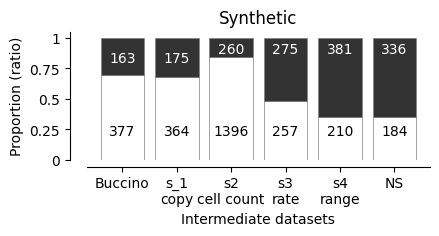

In [18]:
# setup parameters
FIGSIZE = (4.5, 2.5)
SHIFT = 0.3
exp_names = ('Buccino', 's_1\ncopy', 's2\ncell count', 's3\nrate', 's4\nrange', 'NS')
number_pos = {'exp1_x':-0.3 + SHIFT, 'exp1_y_su': 0.2, 'exp1_y_mu': 0.8,
              'exp2_x': 0.7 + SHIFT, 'exp2_y_su': 0.2, 'exp2_y_mu': 0.8,
              'exp3_x': 1.7 + SHIFT, 'exp3_y_su': 0.2, 'exp3_y_mu': 0.87,
              'exp4_x': 2.7 + SHIFT, 'exp4_y_su': 0.2, 'exp4_y_mu': 0.87,
              'exp5_x': 3.7 + SHIFT, 'exp5_y_su': 0.2, 'exp5_y_mu': 0.87,
              'exp6_x': 4.7 + SHIFT, 'exp6_y_su': 0.2, 'exp6_y_mu': 0.87}
legend_cfg = {"frameon": False, "handletextpad": 0.1}

# compute data
plot_data = process_each_experiment(SORTED_ks4_paths['Buccino'], SORTED_ks4_paths['s_1\ncopy'], 
                                    SORTED_ks4_paths['s2\ncell count'], SORTED_ks4_paths['s3\nrate'], SORTED_ks4_paths['s4\nrange'], 
                                    SORTED_ks4_paths['NS'], exp_names)

# setup plot
_, ax = plt.subplots(1,1,figsize=FIGSIZE)

# plot (white: single-unit; black: multi-units)
isolation.plot_unit_isolation_pros_of_added_detailed(ax, plot_data['Buccino'], 
                                                     plot_data['s_1\ncopy'], plot_data['s2\ncell count'], plot_data['s3\nrate'], 
                                                     plot_data['s4\nrange'], plot_data['NS'], 
                                                     legend_cfg, number_pos, exp_names)

# legend
ax.set_yticks([0, 0.25, 0.5, 0.75, 1], [0, 0.25, 0.5, 0.75, 1])
ax.set_title('Synthetic')
plt.tight_layout()

# save figures
plt.savefig(
    "figures/7_reviews/figxx_pros_of_added_details_2.svg",
    **savefig_cfg,
)

- the absolute value matters (the single yield and ratio (optionallym))

- we can test the different spike sorters on these simulations

hyp:

Calculate the yield within 50 um for buccino too.

Things we can't do:
- 

In [ ]:
# # check firing rates
# # cell_type = get_cell_type_property_from_mearec(RecGenS3)
# # firing_rates= get_firing_rates(SortingS3, duration_s=600)
# # print(np.array(firing_rates)[cell_type=='E'].mean())
# # print(np.array(firing_rates)[cell_type=='I'].mean())

# firing_ranges = get_firing_ranges(WeGtNS)
# print("\nNS")
# display(firing_ranges.max())
# display(firing_ranges[SortingGtNS.get_property('synapse_class')=='EXC'].std())
# display(firing_ranges[SortingGtNS.get_property('synapse_class')=='INH'].std())

# firing_ranges = get_firing_ranges(WeGtS3)
# print("\nS3")
# display(firing_ranges.max())
# display(firing_ranges[:200].std())
# display(firing_ranges[201:].std())

# firing_ranges = get_firing_ranges(WeGtS4)
# print("\nS4")
# display(firing_ranges.max())
# display(firing_ranges[:200].std())
# display(firing_ranges[201:].std())

# snrs
snrs_s4 = get_waveform_snr(WeGtS4)
print('\n',snrs_s4.min(), snrs_s4.max(), np.median(snrs_s4))

snrs_ns = get_waveform_snr(WeGtNS)
print(np.nanmin(snrs_ns), np.max(snrs_ns[np.isfinite(snrs_ns)]), np.median(snrs_ns[np.isfinite(snrs_ns)]))

# amplitudes
amplitudes_c = get_waveform_amplitude_medians(WeGtS4)
print('\n', np.nanmin(amplitudes_c), np.max(amplitudes_c[np.isfinite(amplitudes_c)]), np.median(amplitudes_c[np.isfinite(amplitudes_c)]))

amplitudes_c = get_waveform_amplitude_medians(WeGtNS)
print(np.nanmin(amplitudes_c), np.max(amplitudes_c[np.isfinite(amplitudes_c)]), np.median(amplitudes_c[np.isfinite(amplitudes_c)]))

# noise_level 10 uV (mad -> 11.53 - ok)
# TODO: make noise level 2.44 instead of 10 uV
# TODO: make amplitude level 2.44 instead of 10 uV
RecordingS4 = si.load_extractor(RECORDING_S4_PATH)
traces = RecordingS4.get_traces()
print('\n', mad(traces[:,0]))

RecordingNS = si.load_extractor(RECORDING_NS_PATH)
traces = RecordingNS.get_traces()
l5 = np.where(RecordingNS.get_property('layers')=='L5')[0]
print(mad(traces[:, l5[0]]))


 0.0 38.075542 11.97565
0.18076326 75.71147 3.8221085

 85.42227 555.2931 178.55473
1.0 227.0 8.0

 11.534774
2.444634


## Clean up

In [ ]:
# clean up default temporary data - you will need to reinstall mearec afterward with pip intall mearec
import shutil

shutil.rmtree(WAVEFORM_GT_BUCCINO_PATH, ignore_errors=True)
shutil.rmtree(WAVEFORM_GT_CLONE_PATH, ignore_errors=True)
shutil.rmtree(WAVEFORM_GT_S2_PATH, ignore_errors=True)
shutil.rmtree(WAVEFORM_GT_S3_PATH, ignore_errors=True)
shutil.rmtree(WAVEFORM_GT_NS_PATH, ignore_errors=True)

# shutil.rmtree(CELLS_PATH, ignore_errors=True)

## Supplementary methods

TODO:
- store our cell positions and use them in buccino's simulation to get the exact same cell locations.
- number of single-units should increase by f^3 (upper bound)
- conclusion: it is important to use biological cell densities, which we use.

### Cell locations

- The MEA probes are located on the yz plane, with an adjustable x-offset (offset) set to 0  by default.

In [5]:
# get S2 cell locations
GtS2 = si.load_extractor(GROUND_TRUTH_S2_PATH)
locS2 = GtS2.get_property('soma_position')

print('x (depth):')
print('-min:', locS2[:,0].min())
print('-max:', locS2[:,0].max())
print('\ny:')
print('-min:', locS2[:,1].min())
print('-max:', locS2[:,1].max())
print('\nz:')
print('-min:', locS2[:,2].min())
print('-max:', locS2[:,2].max())

# get NS cell locations
GtNS = si.load_extractor(GROUND_TRUTH_NS_PATH)
loc = get_cell_locations(GtNS)

print('\nx (depth):')
print('-min:', loc[:,0].min())
print('-max:', loc[:,0].max())
print('\ny:')
print('-min:', loc[:,1].min())
print('-max:', loc[:,1].max())
print('\nz:')
print('-min:', loc[:,2].min())
print('-max:', loc[:,2].max())

x (depth):
-min: -49.928803122976774
-max: 49.8361459345757

y:
-min: -73.96579222038521
-max: 73.79318388072528

z:
-min: -1000.5337516271763
-max: 1000.807144455734

x (depth):
-min: 3263.91095188888
-max: 4562.37147835935

y:
-min: -1485.1126678433502
-max: -987.4235813424148

z:
-min: -3233.206345506907
-max: -1723.7586189692386


40.0
25.612496949731394
max cell to cell distance: 2002.312123185693


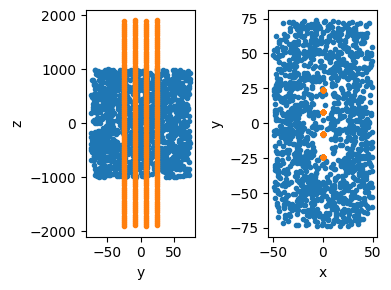

In [6]:
GtS2 = si.load_extractor(GROUND_TRUTH_S2_PATH)
locS2 = GtS2.get_property('soma_position')

recS2 = si.load_extractor(RECORDING_S2_PATH)
site_locS2 = recS2.get_property('location')
site_locS2 = np.insert(site_locS2, 0, 0, axis=1)
print(_euclidean_distance(site_locS2[0,:], site_locS2[1,:]))
print(_euclidean_distance(site_locS2[0,:], site_locS2[96,:]))

fig, ax = plt.subplots(1,2, figsize=(4,3))

ax[0].plot(locS2[:,1], locS2[:,2],'.')
ax[0].plot(site_locS2[:,1], site_locS2[:,2],'.')
ax[0].set_xlabel('y')
ax[0].set_ylabel('z')

ax[1].plot(locS2[:,0], locS2[:,1],'.')
ax[1].plot(site_locS2[:,0], site_locS2[:,1],'.')
ax[1].set_xlabel('x')
ax[1].set_ylabel('y')

plt.tight_layout()

# print max cell distance
d = cdist(locS2, locS2)
np.fill_diagonal(d, np.nan)
print('max cell to cell distance:', np.nanmax(d))

39.99999999999982
25.612496949731355
max cell to cell distance: 2004.5641900203805


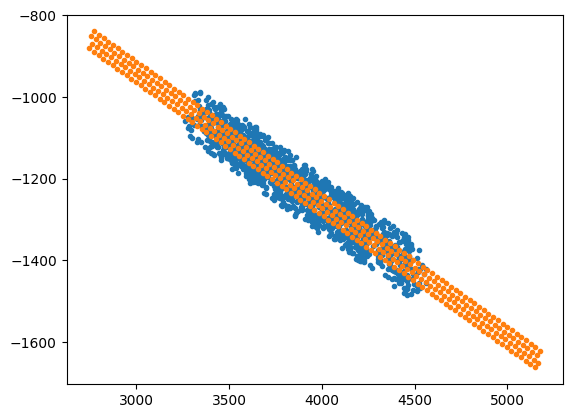

In [7]:
GtNS = si.load_extractor(GROUND_TRUTH_NS_PATH)
locNS = get_cell_locations(GtNS)

recNS = si.load_extractor(RECORDING_NS_PATH)
site_locNS = recNS.get_property('location')
print(_euclidean_distance(site_locNS[0,:], site_locNS[1,:]))
print(_euclidean_distance(site_locNS[0,:], site_locNS[96,:]))

plt.plot(locNS[:,0], locNS[:,1],'.')
plt.plot(site_locNS[:,0], site_locNS[:,1],'.')

# print max cell distance
d = cdist(locNS, locNS)
np.fill_diagonal(d, np.nan)
print('max cell to cell distance:', np.nanmax(d))

### Cell pairwise distances

Mean cell distance:
Buccino: 36.16760719122846 um
S1: 29.431237656752366 um
S2: 15.656075336982537 um
NS: 14.802049129567246 um

Minimum cell distance:
Buccino: 25.13684631204283 um
S1: 4.805265972690439 um
S2: 2.2498413572562 um
NS: 1.648893994466453 um

Maximum cell distance:
Buccino: 66.31955554043584 um
S1: 91.31513646014825 um
S2: 44.079076800718525 um
NS: 44.11195332754986 um

Mean cell distance:
Buccino: 36.16760719122846 um
S1: 29.431237656752366 um
S2: 15.656075336982537 um
NS: 14.802049129567246 um

Minimum cell distance:
Buccino: 25.13684631204283 um
S1: 4.805265972690439 um
S2: 2.2498413572562 um
NS: 1.648893994466453 um

Maximum cell distance:
Buccino: 66.31955554043584 um
S1: 91.31513646014825 um
S2: 44.079076800718525 um
NS: 44.11195332754986 um


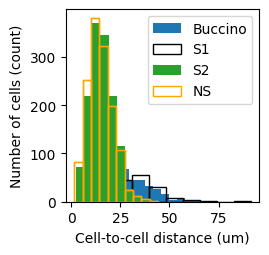

In [8]:
# plot
fig, ax = plt.subplots(1,1, figsize=(2.5, 2.5))

# cell pairwise distances Buccino
GtBuccino = si.load_extractor(GROUND_TRUTH_BUCCINO_PATH)
loc = GtBuccino.get_property('soma_location')
d_buccino = cdist(loc, loc, metric='euclidean')
np.fill_diagonal(d_buccino, np.nan)
d_buccino = np.nanmin(d_buccino, axis=0)
ax.hist(d_buccino)

# cell pairwise distances S1
GtS1 = si.load_extractor(GROUND_TRUTH_S1_PATH)
loc = GtS1.get_property('soma_position')
d_s1 = cdist(loc, loc, metric='euclidean')
np.fill_diagonal(d_s1, np.nan)
d_s1 = np.nanmin(d_s1, axis=0)
ax.hist(d_s1, facecolor='None', edgecolor='k')

# cell pairwise distances S2
GtS2 = si.load_extractor(GROUND_TRUTH_S2_PATH)
loc = GtS2.get_property('soma_position')
d_s2 = cdist(loc, loc, metric='euclidean')
np.fill_diagonal(d_s2, np.nan)
d_s2 = np.nanmin(d_s2, axis=0)
ax.hist(d_s2)

# cell pairwise distances NS
GtNS = si.load_extractor(GROUND_TRUTH_NS_PATH)
d_ns = get_cell_to_cell_distances(GtNS)
np.fill_diagonal(d_ns, np.nan)
d_ns = np.nanmin(d_ns, axis=0)

ax.hist(d_ns, facecolor='None', edgecolor='orange');
ax.set_xlabel('Cell-to-cell distance (um)');
ax.set_ylabel('Number of cells (count)');
ax.legend(['Buccino', 'S1', 'NS'])

print('Mean cell distance:')
print('Buccino:', d_buccino.mean(), 'um')
print('S1:', d_s1.mean(), 'um')
print('S2:', d_s2.mean(), 'um')
print('NS:', d_ns.mean(), 'um')

print('\nMinimum cell distance:')
print('Buccino:', d_buccino.min(), 'um')
print('S1:', d_s1.min(), 'um')
print('S2:', d_s2.min(), 'um')
print('NS:', d_ns.min(), 'um')

print('\nMaximum cell distance:')
print('Buccino:', d_buccino.max(), 'um')
print('S1:', d_s1.max(), 'um')
print('S2:', d_s2.max(), 'um')
print('NS:', d_ns.max(), 'um')

# cell pairwise distances NS
GtNS = si.load_extractor(GROUND_TRUTH_NS_PATH)
d_ns = get_cell_to_cell_distances(GtNS)
np.fill_diagonal(d_ns, np.nan)
d_ns = np.nanmin(d_ns, axis=0)

ax.hist(d_ns, facecolor='None', edgecolor='orange');
ax.set_xlabel('Cell-to-cell distance (um)');
ax.set_ylabel('Number of cells (count)');
ax.legend(['Buccino', 'S1', 'S2', 'NS'])

print('\nMean cell distance:')
print('Buccino:', d_buccino.mean(), 'um')
print('S1:', d_s1.mean(), 'um')
print('S2:', d_s2.mean(), 'um')
print('NS:', d_ns.mean(), 'um')

print('\nMinimum cell distance:')
print('Buccino:', d_buccino.min(), 'um')
print('S1:', d_s1.min(), 'um')
print('S2:', d_s2.min(), 'um')
print('NS:', d_ns.min(), 'um')

print('\nMaximum cell distance:')
print('Buccino:', d_buccino.max(), 'um')
print('S1:', d_s1.max(), 'um')
print('S2:', d_s2.max(), 'um')
print('NS:', d_ns.max(), 'um')

### Nb of cells w/n 50 um

In [4]:
# load dataset
RecordingS1 = si.load_extractor(RECORDING_S1_PATH)
SortingGtS1 = si.load_extractor(GROUND_TRUTH_S1_PATH)

# get cell and site positions
site_pos = RecordingS1.get_channel_locations()
site_pos = np.hstack((np.zeros((site_pos.shape[0], 1)), site_pos))
cell_pos = SortingGtS1.get_property('soma_position')
unit_ids = SortingGtS1.unit_ids

num_cells = count_near_cells_within_radius(site_pos, cell_pos, unit_ids, radius=50)
print('number of cells:', num_cells)

number of cells: 168


In [9]:
# load dataset
RecordingS2 = si.load_extractor(RECORDING_S2_PATH)
SortingGtS2 = si.load_extractor(GROUND_TRUTH_S2_PATH)

# get cell and site positions
site_pos = RecordingS2.get_channel_locations()
site_pos = np.hstack((np.zeros((site_pos.shape[0], 1)), site_pos))
cell_pos = SortingGtS2.get_property('soma_position')
unit_ids = SortingGtS2.unit_ids

num_cells = count_near_cells_within_radius(site_pos, cell_pos, unit_ids, radius=50)
print('number of cells:', num_cells)

number of cells: 1188


In [7]:
# load dataset
RecordingNS = si.load_extractor(RECORDING_NS_PATH)
SortingGtNS = si.load_extractor(GROUND_TRUTH_NS_PATH)

# get cell and site positions
cell_pos = np.array([SortingGtNS.get_property('x'), SortingGtNS.get_property('y'), SortingGtNS.get_property('z')]).T
site_pos = RecordingNS.get_property('location')
unit_ids = SortingGtNS.unit_ids

# count cells w/n radius of the electrodes
num_cells = count_near_cells_within_radius(site_pos, cell_pos, unit_ids, radius=50)
print('number of cells:', num_cells)

number of cells: 1388


### Cell densities

### Exc and inh cell counts

In [ ]:
SortingGtNS = si.load_extractor(GROUND_TRUTH_NS_PATH)
print('inh count', len(np.array(firing_rates)[SortingGtNS.get_property('synapse_class')=='INH']))
print('exc count', len(np.array(firing_rates)[SortingGtNS.get_property('synapse_class')=='EXC']))